In [1]:
import nbimporter

import numpy as np
from s04_01_general_Q import get_Q_T_H_d_t_i

Importing Jupyter notebook from s04_01_general_Q.ipynb


## 第四節　FF暖房機 / Section 4  FF type heating

1．適用範囲～4．記号及び単位は省略

1. Scope of application ~ 4. Symbols and units are omitted

### 5．最大暖房出力 / Maximum heating output

$$\large
Q_{max,H,d,t} = q_{max,H} \times 3600 \times 10^{-6}
$$

$Q_{max,H,d,t}$：日付$d$の時刻$t$における1時間当たりの最大暖房出力(MJ/h) / Maximum heating output per hour at time $ t $ of date $ d $  
$q_{max,H}$：最大暖房能力(W) / Maximum heating capacity

In [2]:
def get_Q_max_H_d_t(q_max_H):
    """最大暖房出力
    
    :param q_max_H: 最大暖房能力
    :type q_max_H: float
    :return: 最大暖房出力
    :rtype: ndarray
    """
    return np.ones(24 * 365) * q_max_H * 3600 * 10 ** (-6)  # (1)


### 6．暖房エネルギー消費量 / Heating energy consumption

#### 6.1　消費電力量 / Power consumption

$$
\large
E_{E,H,d,t} = \left\{ \begin{array}{ll}
    P_{rtd,H} \times \frac{Q_{T,H,d,t}}{Q_{max,H,d,t}} \times 10^{-3} & \small(Q_{T,H,d,t} \ge q_{min,H} \times 3600 \times 10^{-6}の場合)\\ 
    \left(P_{rtd,H} \times \frac{Q_{T,H,d,t}}{Q_{max,H,d,t}} + P_{itm,H} \right) \times 10^{-3} & \small(Q_{T,H,d,t} \lt q_{min,H} \times 3600 \times 10^{-6}の場合)\\ 
    \end{array}
\right.
$$

$E_{E,H,d,t}$：日付$d$の時刻$t$における1時間当たりの消費電力量(kWh/h) / Power consumption per hour at time $ t $ of date $ d $  
$q_{min,H}$：連続運転時最小能力(W) / Minimum capacity during continuous operation  
$P_{rtd,H}$：定格暖房消費電力(W) / Rated heating power consumption  
$P_{itm,H}$：断続時消費電力(W) / Intermittent power consumption  
$Q_{T,H,d,t}$：日付$d$の時刻$t$における1時間当たりの処理暖房負荷(MJ/h) / Processing heating load per hour at time $ t $ of date $ d $  
$Q_{max,H,d,t}$：日付$d$の時刻$t$における1時間当たりの最大暖房出力(MJ/h) / Maximum heating output per hour at time $ t $ of date $ d $  

日付$d$の時刻$t$における1時間当たりの処理暖房負荷$Q_{T,H,d,t}$が 0 の場合、$E_{E,H,d,t} = 0$とする。

If the processing heating load $ Q_{T, H, d, t} $ is 0 at time $ t $ of date $ d $, then $ E_{E, H, d, t} = 0 $ .

In [3]:
def calc_E_E_H_d_t(q_max_H, q_min_H, P_rtd_H, P_itm_H, L_H_d_t):
    """消費電力量
    
    :param q_max_H: 最大暖房能力
    :type q_max_H: float
    :param q_min_H: 連続運転時最小能力
    :type q_min_H: float
    :param P_rtd_H: 定格暖房消費電力
    :type P_rtd_H: float
    :param P_itm_H: 断続時消費電力
    :type P_itm_H: float
    :param L_H_d_t: 暖冷房区画の１時間当たりの暖房負荷
    :type L_H_d_t: ndarray
    :return: 消費電力量
    :rtype: ndarray
    """
    # 最大暖房出力
    Q_max_H_d_t = get_Q_max_H_d_t(q_max_H)

    # 処理暖房負荷
    Q_T_H_d_t = get_Q_T_H_d_t_i(Q_max_H_d_t, L_H_d_t)

    # 消費電力量
    tmp1 = P_rtd_H * Q_T_H_d_t / Q_max_H_d_t * 10 ** (-3)
    tmp1[Q_T_H_d_t < q_min_H * 3600 * 10 ** (-6)] = 0.0

    tmp2 = (P_rtd_H * Q_T_H_d_t / Q_max_H_d_t + P_itm_H) * 10 ** (-3)
    tmp2[Q_T_H_d_t >= q_min_H * 3600 * 10 ** (-6)] = 0.0

    E_E_H_d_t = tmp1 + tmp2

    # ただし、Q_T_H_d_tが0の場合は0
    E_E_H_d_t[Q_T_H_d_t == 0] = 0

    return E_E_H_d_t


#### 6.2　ガス消費量 / Gas consumption

日付$d$の時刻$t$における１時間当たりのガス消費量$E_{G,H,d,t}$は、FF暖房機の燃料がガスの場合日付$d$の時刻$t$における１時間当たりの燃料消費量$E_{F,H,d,t}$に等しいとし、FF暖房機の燃料が灯油の場合0とする。

Gas consumption $ E_{G, H, d, t} $ per hour at time $ t $ of date $ d $ is $ d $ at time $ t $ of date $ d $ when the fuel for the FF heater is gas It is assumed that the fuel consumption per hour is $ E_{F, H, d, t} $, and it is 0 when the fuel of the FF heater is kerosene.

In [4]:
def calc_E_G_H_d_t(fuel, q_max_H, e_rtd_H, L_H_d_t):
    """ガス消費量
    
    :param fuel: 'G'か'K'の値をとる
    :type fuel: string
    :param q_max_H: 最大暖房能力
    :type q_max_H: float
    :param e_rtd_H: 定格暖房エネルギー消費効率
    :type e_rtd_H: float
    :param L_H_d_t: 暖冷房区画の１時間当たりの暖房負荷
    :type L_H_d_t: ndarray
    :raises ValueError:  fuel が 'G'か'K' 以外の場合に発生する
    :return: ガス消費量
    :rtype: ndarray
    """
    if fuel == 'G':
        return calc_E_F_H_d_t(q_max_H, e_rtd_H, L_H_d_t)
    elif fuel == 'K':
        return np.zeros(24 * 365)
    else:
        raise ValueError(fuel)


#### 6.3　灯油消費量 / Kerosene consumption

日付$d$の時刻$t$における１時間当たりの灯油消費量$E_{K,H,d,t}$は、FF暖房機の燃料が灯油の場合日付$d$の時刻$t$における１時間当たりの燃料消費量$E_{F,H,d,t}$に等しいとし、FF暖房機の燃料がガスの場合0とする。

The kerosene consumption $ E_{K, H, d, t} $ per hour at the time $ t $ of the date $ d $ is the time $ t $ of the date $ d $ when the fuel for the FF heater is kerosene It is assumed that the fuel consumption per hour is $ E_{F, H, d, t} $, and is 0 when the fuel of the FF heater is gas.

In [5]:
def calc_E_K_H_d_t(fuel, q_max_H, e_rtd_H, L_H_d_t):
    """灯油消費量
    
    :param fuel: 'G'か'K'の値をとる
    :type fuel: string
    :param q_max_H: 最大暖房能力
    :type q_max_H: float
    :param e_rtd_H: 定格暖房エネルギー消費効率
    :type e_rtd_H: float
    :param L_H_d_t: 暖冷房区画の１時間当たりの暖房負荷
    :type L_H_d_t: ndarray
    :raises ValueError:  fuel が 'G'か'K' 以外の場合に発生する
    :return: 灯油消費量
    :rtype: ndarray
    """
    if fuel == 'K':
        return calc_E_F_H_d_t(q_max_H, e_rtd_H, L_H_d_t)
    elif fuel == 'G':
        return np.zeros(24 * 365)
    else:
        raise ValueError(fuel)


#### 6.4　その他の燃料による一次エネルギー消費量 / Primary energy consumption by other fuels

日付$d$の時刻$t$における１時間当たりのその他の燃料による一次エネルギー消費量$E_{M,H,d,t}$は、0とする。

Primary energy consumption $ E_{M, H, d, t} $ by other fuel per hour at time $ t $ of date $ d $ is 0.

In [6]:
def get_E_M_H_d_t():
    """その他の燃料による一次エネルギー消費量
    
    :return: その他の燃料による一次エネルギー消費量
    :rtype: ndarray
    """
    return np.zeros(24 * 365)


### 7．燃料消費量 / Fuel consumption

$$\large
E_{F,H,d,t} = \frac{Q_{T,H,d,t}}{e_{rtd,H}}
$$

$E_{F,H,d,t}$：日付$d$の時刻$t$における1時間当たりの燃料消費量(MJ/h) / Fuel consumption per hour at time $ t $ of date $ d $  
$Q_{T,H,d,t}$：日付$d$の時刻$t$における1時間当たりの処理暖房負荷(MJ/h) / Processing heating load per hour at time $ t $ of date $ d $  
$e_{rtd,H}$：定格燃焼効率 / Rated combustion efficiency  

In [7]:
def calc_E_F_H_d_t(q_max_H, e_rtd_H, L_H_d_t):
    """燃料消費量
    
    :param q_max_H: 最大暖房能力
    :type q_max_H: float
    :param e_rtd_H: 定格暖房エネルギー消費効率
    :type e_rtd_H: float
    :param L_H_d_t: 暖冷房区画の１時間当たりの暖房負荷
    :type L_H_d_t: ndarray
    :return: 燃料消費量
    :rtype: ndarray
    """
    # 最大暖房出力
    Q_max_H_d_t = get_Q_max_H_d_t(q_max_H)

    # 処理暖房負荷
    Q_T_H_d_t = get_Q_T_H_d_t_i(Q_max_H_d_t, L_H_d_t)

    E_F_H_d_t = Q_T_H_d_t / e_rtd_H  # (3)

    return E_F_H_d_t


## 付録 A 機器の性能を表す仕様の決定方法 / Appendix A How to determine the specification that represents the performance of the device

### A.1　記号及び単位 / Symbol and unit

省略

ommision

### A.2　最大暖房能力 / Maximum heating capacity

$$\large
q_{max,H} = 240.1 \times A_{HCZ}
$$

$q_{max,H}$：最大暖房能力(W) / Maximum heating capacity  
$A_{HCZ}$：FF暖房機により暖房される暖冷房区画の床面積(m<sup>2</sup>) / Floor area of heating and cooling compartments heated by FF heaters  

In [8]:
def get_q_max_H(A_HCZ):
    """最大暖房能力
    
    :param A_HCZ: 暖冷房区画の床面積
    :type A_HCZ: float
    :return: 最大暖房能力
    :rtype: float
    """
    return 240.1 * A_HCZ  # (1)


### A.3　連続運転時最小能力 / Minimum capacity during continuous operation

連続運転時最小能力$q_{min,H}$が0を下回る場合は0とする。

When the continuous running minimum capacity $ q_{min, H} $ is less than 0, it is 0.

$$\large
q_{min,H} = 0.4334 \times q_{max,H} - 540.1
$$

$q_{min,H}$：連続運転時最小能力(W) / Minimum capacity during continuous operation

In [9]:
def get_q_min_H(q_max_H):
    """連続運転時最小能力
    
    :param q_max_H: 最大暖房能力
    :type q_max_H: float
    :return: 連続運転時最小能力
    :rtype: float
    """
    q_min_H = 0.4334 * q_max_H - 540.1  # (2)
    return max(0.0, q_min_H)


### A.4　定格燃焼効率 / Rated combustion efficiency

定格燃焼効率$e_{trd,H}$は0.860（86.0%）とするか、ガスを燃料にするものについては JIS S 2122 に定められた測定方法による熱効率又は灯油を燃料にするものについては JIS S 3031 に定められた測定方法による空気を暖める方式の機器の熱効率を確認し、1000 分の 1 未満の端数を四捨五入し小数第三位までの値とする。

The rated combustion efficiency $ e_{trd, H} $ is set to 0.860 (86.0%), or for those using gas as the fuel, thermal efficiency according to the measurement method defined in JIS S 2122, or those using kerosene as the fuel Check the thermal efficiency of the air heating system according to the measurement method specified in S3031 and round off fractions less than 1/1000 to obtain a value up to the third decimal place.

In [10]:
def get_e_rtd_H_default():
    """定格燃料効率
    
    :return: 定格燃料効率
    :rtype: float
    """
    return 0.860


In [11]:
def get_e_rtd_H(e_rtd_H_raw):
    return round(e_rtd_H_raw * 1000) / 1000


### A.5　定格暖房消費電力 / Rated heating power consumption

$$\large
P_{rtd,H} = 3.13 \times 10^{-3} \times q_{max,H}
$$

$P_{rtd,H}$：定格暖房消費電力(W) / Rated heating power consumption

In [12]:
def get_P_rtd_H(q_max_H):
    """定格暖房消費電力
    
    :param q_max_H: 最大暖房能力
    :type q_max_H: float
    :return: 定格暖房消費電力
    :rtype: float
    """
    return 3.13 / 1000 * q_max_H  # (3)


### A.6　断続時消費電力 / Intermittent power consumption

断続時消費電力$P_{itm,H}$は、40.0Wとする。

The intermittent power consumption $ P_{itm, H} $ is 40.0 W.

In [13]:
def get_P_itm_H():
    """断続時消費電力
    
    :return: 断続時消費電力
    :rtype: float
    """
    return 40.0


### A.7　複数のFF暖房機が設置される場合の仕様の決定方法 / How to determine the specifications when multiple FF heaters are installed

「主たる居室」に 2 台以上の暖房機が設置される場合、「その他の居室」に 2 台以上の暖房機が設置される場合又は複数の「その他の居室」においてそれぞれに暖房機が設置される場合は、「主たる居室」及び「その他の居室」それぞれにおいて、複数の機器の定格燃焼効率のうち最も小さい値を採用することとする。

When two or more heaters are installed in the "main room", two or more heaters are installed in the "other rooms", or a heater is installed in each of the "other rooms" In this case, in each of the “main room” and the “other room”, the smallest value among the rated combustion efficiencies of the plurality of devices is adopted.

In [14]:
def get_e_rtd_from_multi_devices(e_rtd_list):
    """複数の FF 暖房機が設置される場合の仕様の決定方法
    
    :param e_rtd_list: 定格エネルギー消費効率の配列
    :type e_rtd_list: list
    :return: 複数の FF 暖房機が設置される場合の仕様の決定方法
    :rtype: float
    """
    return min(e_rtd_list)


## 試算例

|名称1|名称2|変数名|計算条件1|計算条件2|計算条件3|計算条件4|計算条件5|計算条件6|計算条件7|計算条件8|計算条件9|
|----|------|--|--|--|--|--|--|--|--|--|--|
|地域の区分|-|$$region$$|6|1|6|6|6|6|6|6|6|
|延床面積|合計|$$A_A$$|120.08|120.08|90|120.08|120.08|120.08|120.08|120.08|120.08|
|延床面積|主居室|$$A_{MR}$$|29.81|29.81|25|29.81|29.81|29.81|29.81|29.81|29.81|
|延床面積|その他居室|$$A_{OR}$$|51.34|51.34|40|51.34|51.34|51.34|51.34|51.34|51.34|
|外皮面積|-|$$A_{env}$$|307.51|307.51|250|307.51|307.51|307.51|307.51|307.51|307.51|
|外皮平均熱貫流率|-|$$U_A$$|0.87|0.87|0.87|0.6|0.87|0.87|0.87|0.87|0.87|
|暖房期平均日射熱取得率|-|$$\eta_{AH}$$|4.3|4.3|4.3|4.3|3.0|4.3|4.3|4.3|4.3|
|冷房期平均日射熱取得率|-|$$\eta_{AC}$$|2.8|2.8|2.8|2.8|2.8|2.0|2.8|2.8|2.8|
|主居室|暖房設備|$$type$$|FF暖房機|FF暖房機|FF暖房機|FF暖房機|FF暖房機|FF暖房機|FF暖房機|FF暖房機|FF暖房機|
|主居室|定格エネルギー消費効率|$$e_{rtd,H}$$|0.860|0.860|0.860|0.860|0.860|0.860|0.750|0.860|0.860|
|その他居室|暖房設備|$$type$$|-|-|-|-|-|-|-|FF暖房機|FF暖房機|
|その他居室|定格エネルギー消費効率|$$e_{rtd,H}$$|-|-|-|-|-|-|-|0.860|0.860|
|暖冷房区画の番号|-|$$i$$|1|1|1|1|1|1|1|4|5|



In [15]:
def calc_Q_UT_H_d_t(q_max_H, L_H_d_t):
    """未処理暖房負荷
    
    :param q_max_H: 最大暖房能力
    :type q_max_H: float
    :param L_H_d_t: 暖冷房区画の１時間当たりの暖房負荷
    :type L_H_d_t: ndarray
    :return: 未処理暖房負荷
    :rtype: ndarray
    """
    # 最大暖房出力
    Q_max_H_d_t = get_Q_max_H_d_t(q_max_H)

    # 処理暖房負荷
    Q_T_H_d_t = get_Q_T_H_d_t_i(Q_max_H_d_t, L_H_d_t)

    # 未処理暖房負荷
    Q_UT_H_d_t = L_H_d_t - Q_T_H_d_t

    return Q_UT_H_d_t


In [16]:
def calc_results(param, H_MR, H_OR, i):

    if __name__ == "__main__":

        from s02_01_b_heat_conversion_coefficient import get_f_prim
        from s03_01_hc_load_general import get_Q, get_A_HCZ_i
        from s03_02_envelope_performance import calc_r_env, get_Q_dash, get_eta_H, get_eta_C
        from s04_01_general import calc_heating_load, get_alpha_UT_H_MR, get_alpha_UT_H_OR
        from s04_01_a_heating_method import calc_heating_mode

        region = param["region"]
        sol_region = None
        A_A = param["A_A"]
        A_MR = param["A_MR"]
        A_OR = param["A_OR"]
        A_env = param["A_env"]
        U_A = param["U_A"]
        eta_A_H = param["eta_A_H"]
        eta_A_C = param["eta_A_C"]
        NV_MR = 0
        NV_OR = 0
        r_A_ufvnt = None
        underfloor_insulation = False
        TS = None
        HEX = None

        mode_C = None
        mode_H = '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合'

        fuel = "G"
        e_rtd_H = H_MR["e_rtd_H"] if i == 1 else H_OR["e_rtd_H"]


        # 暖冷房区画の床面積
        A_HCZ = get_A_HCZ_i(i, A_A, A_MR, A_OR)

        # 機器の性能
        q_max_H = get_q_max_H(A_HCZ)
        q_min_H = get_q_min_H(q_max_H)
        P_rtd_H = get_P_rtd_H(q_max_H)
        P_itm_H = get_P_itm_H()

        # 暖房方式及び運転方法の区分
        mode_MR, mode_OR = calc_heating_mode(region=region, H_MR=H_MR, H_OR=H_OR)

        # 床面積の合計に対する外皮の部位の面積の合計の比
        r_env = calc_r_env(method='当該住戸の外皮の部位の面積等を用いて外皮性能を評価する方法',
                           A_env=A_env, A_A=A_A)

        # 熱損失係数
        Q_dash = get_Q_dash(U_A, r_env)
        Q = get_Q(Q_dash)

        # 日射取得係数
        mu_H = get_eta_H(eta_A_H, r_env)
        mu_C = get_eta_C(eta_A_C, r_env)

        # 暖房負荷
        L_H_d_t = \
            calc_heating_load(region, sol_region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX,
                              underfloor_insulation, mode_H, mode_C, spec_MR=H_MR, spec_OR=H_OR, mode_MR=mode_MR, mode_OR=mode_OR, SHC=None)[0][i-1]

        # エネルギー消費量
        E_E_H_d_t = calc_E_E_H_d_t(q_max_H, q_min_H, P_rtd_H, P_itm_H, L_H_d_t)
        E_G_H_d_t = calc_E_G_H_d_t(fuel, q_max_H, e_rtd_H, L_H_d_t)
        E_K_H_d_t = calc_E_K_H_d_t(fuel, q_max_H, e_rtd_H, L_H_d_t)
        E_M_H_d_t = get_E_M_H_d_t()

        # 未処理暖房負荷の設計一次エネルギー消費量相当値
        Q_UT_H_d_t = calc_Q_UT_H_d_t(q_max_H, L_H_d_t)
        alpha_UT_H = get_alpha_UT_H_MR(region, mode_MR) if i == 1 else get_alpha_UT_H_OR(region, mode_OR)
        E_UT_H_d_t = Q_UT_H_d_t * alpha_UT_H

        f_prim = get_f_prim()
        E_H_d_t = E_E_H_d_t * f_prim / 1000 + E_G_H_d_t + E_K_H_d_t + E_M_H_d_t + E_UT_H_d_t
        print('一次エネルギー消費量:{}MJ/y'.format(np.sum(E_H_d_t)))

        return E_H_d_t


In [17]:
def get_each_graph(_E_H_d_t):

    import matplotlib.pyplot as plt

    _E_H_d = np.sum(_E_H_d_t.reshape(365,24), axis = 1)

    fig = plt.figure(figsize = (20,7))

    grh_day = fig.add_subplot(211)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(_E_H_d, label = "E_H")
    grh_day.legend()

    grh_date = fig.add_subplot(212)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(_E_H_d_t.reshape(365,24)[334], label = "E_H:12/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[59], label = "E_H:3/1")
    grh_date.legend()

    plt.show()


### 計算条件1

In [18]:
param = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8}
H_MR = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
H_OR = None
i = 1

_E_H_d_t_1 = calc_results(param, H_MR, H_OR, i)


Importing Jupyter notebook from s02_01_b_heat_conversion_coefficient.ipynb
Importing Jupyter notebook from s03_01_hc_load_general.ipynb
Importing Jupyter notebook from s03_01_hc_load_general_file.ipynb
Importing Jupyter notebook from s03_01_d_ventilation_via_underfloor.ipynb
Importing Jupyter notebook from s03_01_e_underfloor_temperature.ipynb
Importing Jupyter notebook from s11_01_external_condition.ipynb
Importing Jupyter notebook from s03_02_envelope_performance.ipynb
Importing Jupyter notebook from s03_02_08_envelope_performance_detail.ipynb
Importing Jupyter notebook from s03_02_09_envelope_performance_simple.ipynb
Importing Jupyter notebook from s03_02_b_temperature_difference_coefficient.ipynb
Importing Jupyter notebook from s03_02_c_orientation_coefficient.ipynb
Importing Jupyter notebook from s03_04_solar_heat_gain_coefficient.ipynb
Importing Jupyter notebook from s04_01_general.ipynb
Importing Jupyter notebook from s04_01_a_heating_method.ipynb
Importing Jupyter notebook from

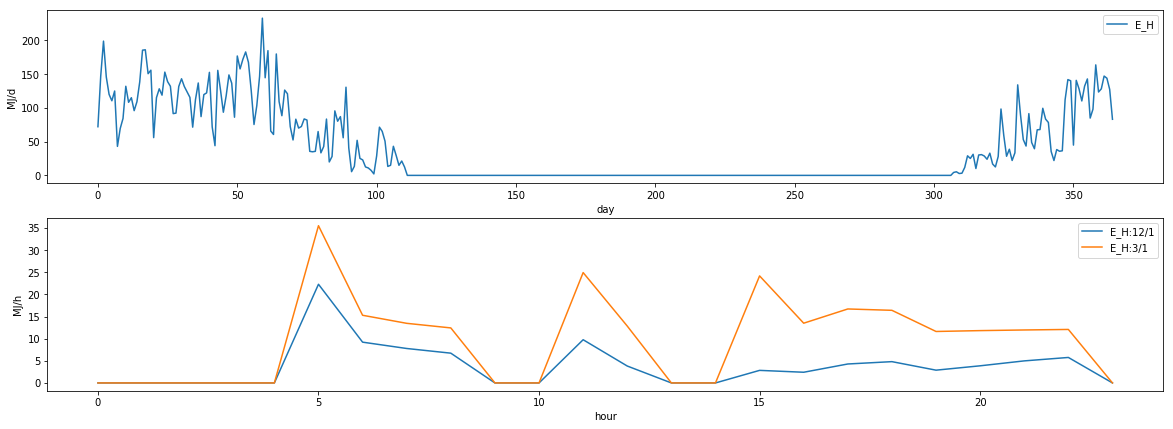

In [19]:
get_each_graph(_E_H_d_t_1)

### 計算条件2

In [20]:
param = {"region": 1, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8}
H_MR = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
H_OR = None
i = 1

_E_H_d_t_2 = calc_results(param, H_MR, H_OR, i)


一次エネルギー消費量:55082.831191244426MJ/y


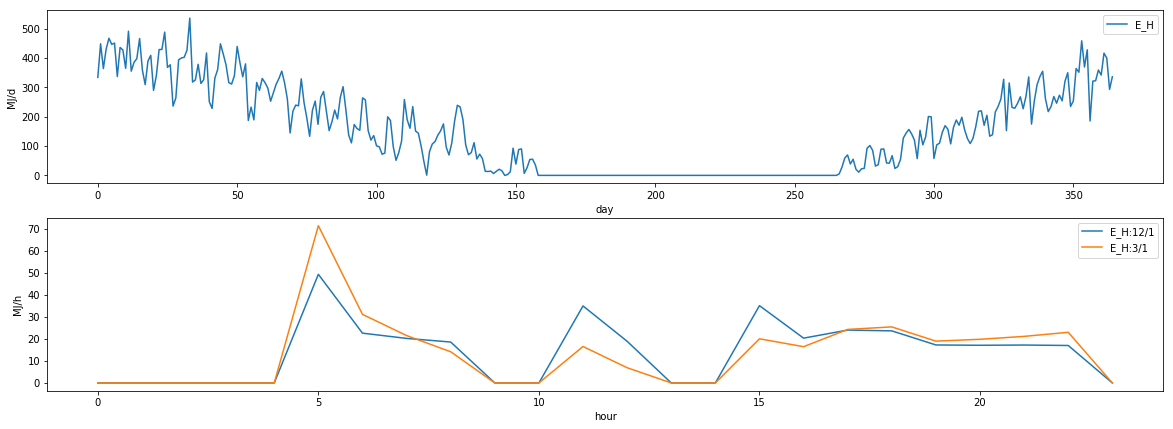

In [21]:
get_each_graph(_E_H_d_t_2)

### 計算条件3

In [22]:
param = {"region": 6, "A_A": 90, "A_MR": 25, "A_OR": 40, "A_env": 250, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8}
H_MR = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
H_OR = None
i = 1

_E_H_d_t_3 = calc_results(param, H_MR, H_OR, i)


一次エネルギー消費量:12926.604927421971MJ/y


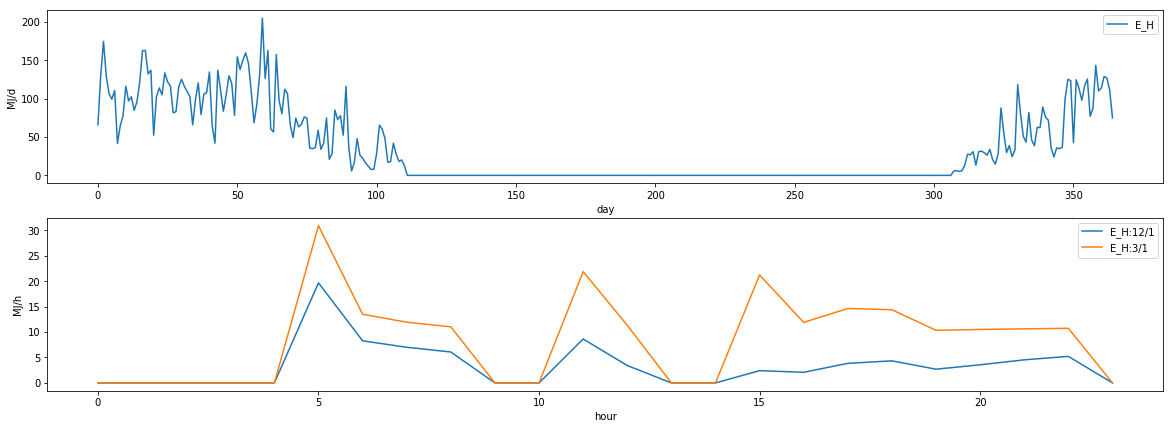

In [23]:
get_each_graph(_E_H_d_t_3)

### 計算条件4

In [24]:
param = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.6, "eta_A_H": 4.3, "eta_A_C": 2.8}
H_MR = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
H_OR = None
i = 1

_E_H_d_t_4 = calc_results(param, H_MR, H_OR, i)


一次エネルギー消費量:8952.37309634613MJ/y


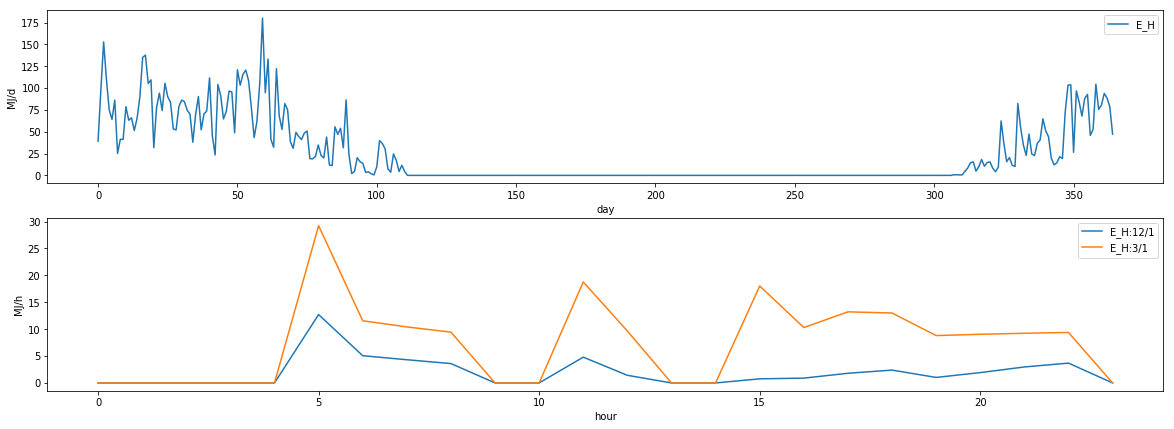

In [25]:
get_each_graph(_E_H_d_t_4)

### 計算条件5

In [26]:
param = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87, "eta_A_H": 3.0, "eta_A_C": 2.8}
H_MR = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
H_OR = None
i = 1

_E_H_d_t_5 = calc_results(param, H_MR, H_OR, i)


一次エネルギー消費量:17476.606193142656MJ/y


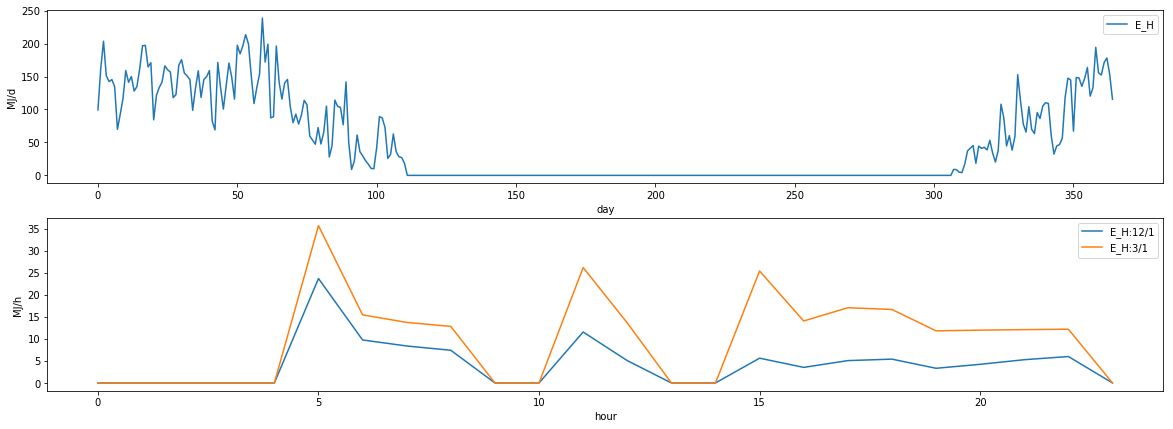

In [27]:
get_each_graph(_E_H_d_t_5)

### 計算条件6

In [28]:
param = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.0}
H_MR = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
H_OR = None
i = 1

_E_H_d_t_6 = calc_results(param, H_MR, H_OR, i)


一次エネルギー消費量:14330.938494398375MJ/y


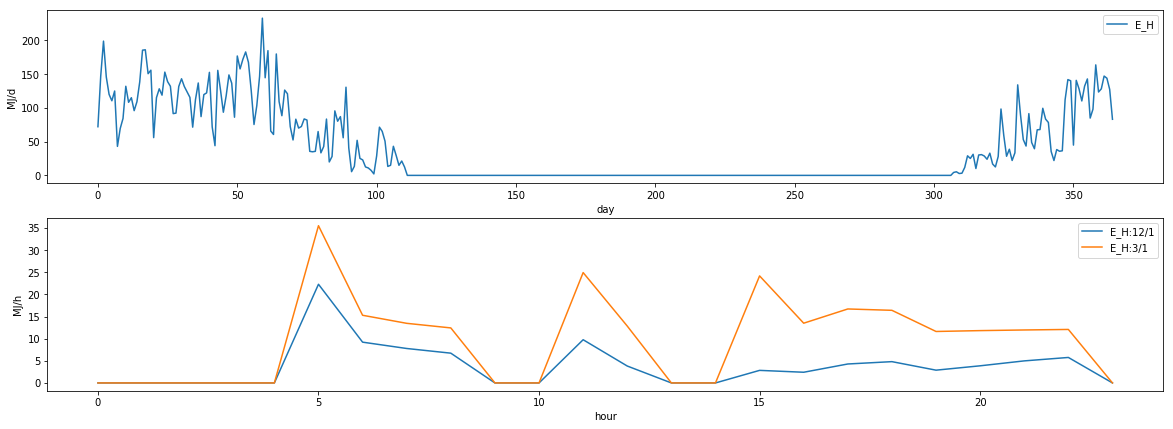

In [29]:
get_each_graph(_E_H_d_t_6)

### 計算条件7

In [30]:
param = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8}
H_MR = {'type': 'FF暖房機', 'e_rtd_H': 0.750}
H_OR = None
i = 1

_E_H_d_t_7 = calc_results(param, H_MR, H_OR, i)


一次エネルギー消費量:16292.88931854348MJ/y


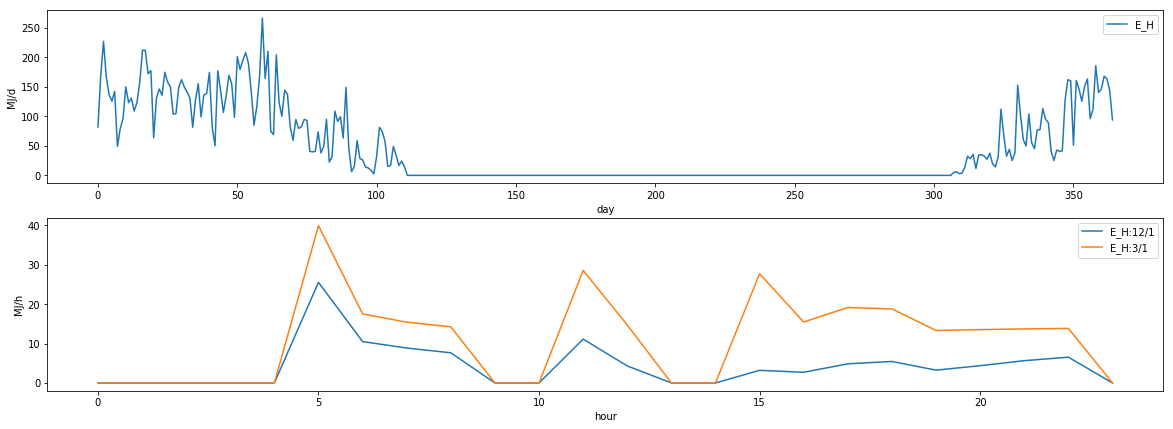

In [31]:
get_each_graph(_E_H_d_t_7)

### 計算条件8

In [32]:
param = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8}
H_MR = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
H_OR = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
i = 4

_E_H_d_t_8 = calc_results(param, H_MR, H_OR, i)


一次エネルギー消費量:2086.8994553484454MJ/y


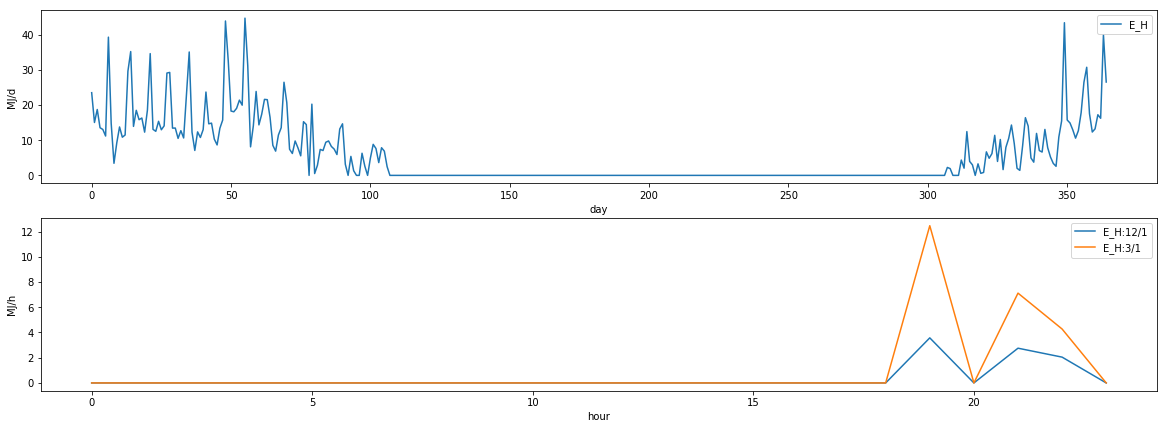

In [33]:
get_each_graph(_E_H_d_t_8)

### 計算条件9

In [34]:
param = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8}
H_MR = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
H_OR = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
i = 5

_E_H_d_t_9 = calc_results(param, H_MR, H_OR, i)


一次エネルギー消費量:1896.1156808220217MJ/y


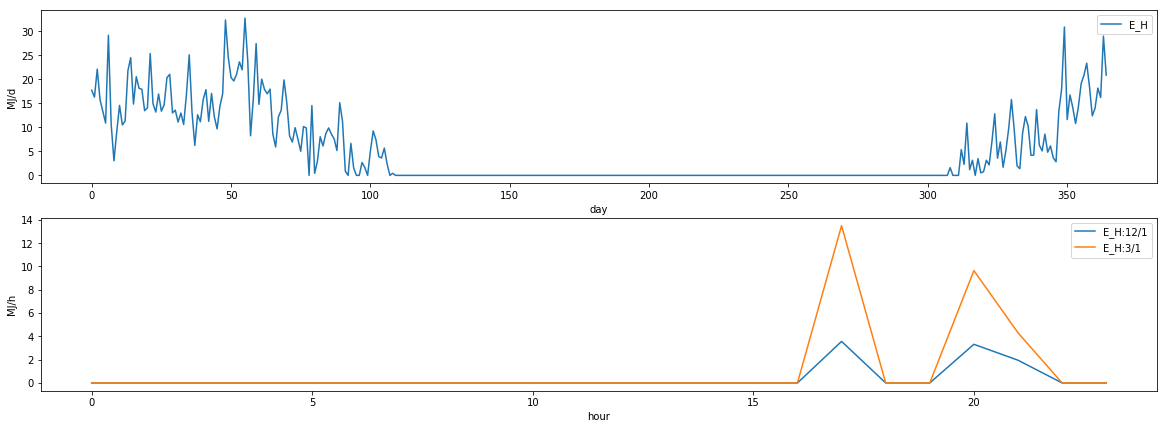

In [35]:
get_each_graph(_E_H_d_t_9)

### 比較

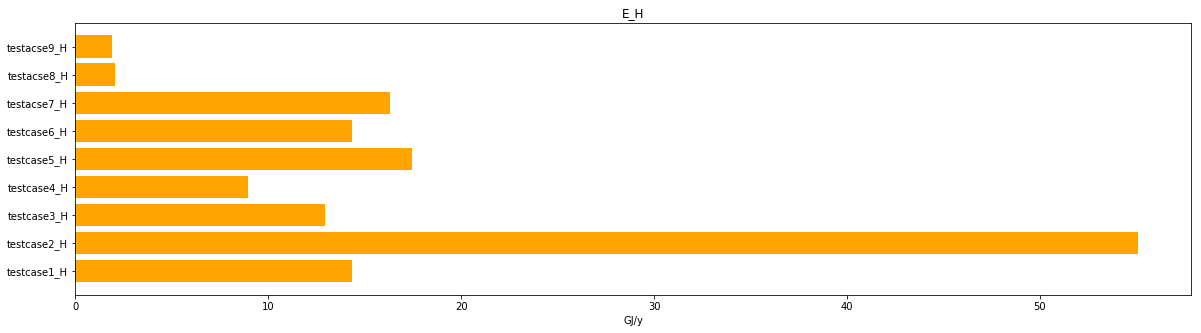

In [36]:
import matplotlib.pyplot as plt

dat_H = {"testcase1_H": np.sum(_E_H_d_t_1)/1000, "testcase2_H": np.sum(_E_H_d_t_2)/1000, "testcase3_H": np.sum(_E_H_d_t_3)/1000, 
         "testcase4_H": np.sum(_E_H_d_t_4)/1000, "testcase5_H": np.sum(_E_H_d_t_5)/1000, "testcase6_H": np.sum(_E_H_d_t_6)/1000,
         "testacse7_H": np.sum(_E_H_d_t_7)/1000, "testacse8_H": np.sum(_E_H_d_t_8)/1000, "testacse9_H": np.sum(_E_H_d_t_9)/1000}

x_H = list(dat_H.keys())
y_H = list(dat_H.values())

fig = plt.figure(figsize=(20,5))

grh_H = fig.add_subplot(111)
grh_H.barh(x_H,y_H, color = "orange")
grh_H.set_xlabel("GJ/y")
grh_H.set_title("E_H")

plt.show()